In [1]:
import sys
from pathlib import Path
import fitz

In [2]:
def main(file_path_list, dpi=150):
    """PDFファイルのページを画像ファイルに変換する
    
    Args:
        file_path_list (list): PDFファイルパス名のリスト
        dpi (int): 画像の解像度（DPI）。デフォルトは150
    """
    for file_path in file_path_list:
        path_file = Path(file_path)
        folder_name = path_file.parent
        base_file_name = path_file.stem

        # PDFファイルを開く
        pdf = fitz.open(file_path)

        # 1ページずつ画像ファイルとして保存する
        for i, page in enumerate(pdf):
            # 解像度を指定してピクスマップを取得
            # dpi/72.0 でスケールファクターを計算（fitz.Matrixのscale値）
            zoom = dpi / 72.0
            mat = fitz.Matrix(zoom, zoom)
            pix = page.get_pixmap(matrix=mat)
            
            image_f_name = f'{base_file_name}_{str(i).zfill(2)}.png'
            image_f_path = Path(folder_name) / image_f_name
            pix.save(image_f_path)
            
        pdf.close()  # PDFファイルを閉じる

In [3]:
if __name__ == '__main__':
    # if len(sys.argv) < 2:
    #     print('PDFファイルを指定してください')
    #     sys.exit()
    
    # 引数2つ目以降処理する
    # 解像度を指定して実行（例：300 DPI）
    main(["/workspace/給与_A3.pdf"], dpi=300)

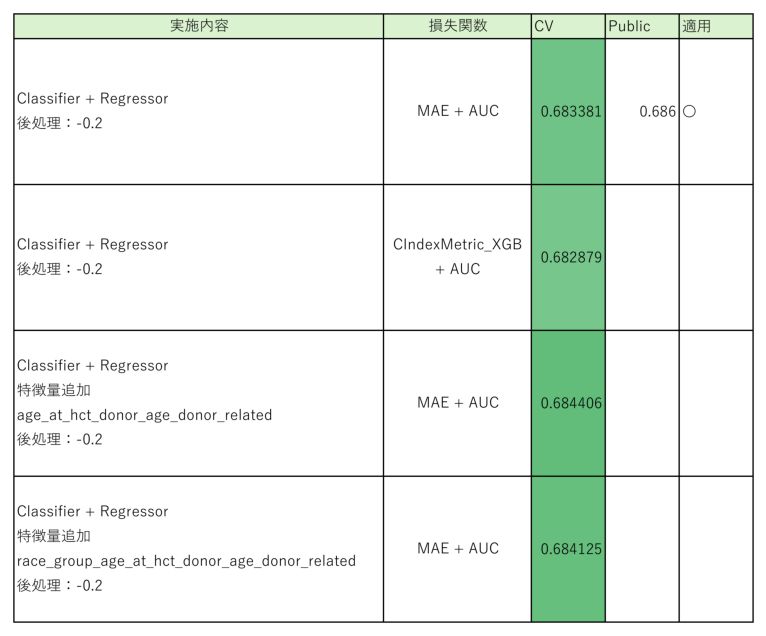

画像を保存しました: 給与_A3_02_cropped.png
検出された有効な輪郭数: 1


In [9]:
# 変換した画像をOpenCVで余白を除去して表示する
import cv2
import numpy as np
from matplotlib import pyplot as plt

image_path = "/workspace/給与_A3_02.png"
# 画像を読み込む
img = cv2.imread(image_path)
# グレースケールに変換
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 二値化（大津の二値化）
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 輪郭を検出
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 面積が一定以上の輪郭のみを対象とする（ノイズ除去）
min_area = 100  # 最小面積を設定（必要に応じて調整）
valid_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]

if valid_contours:
    # すべての有効な輪郭を含む最小の矩形を計算
    all_points = np.vstack(valid_contours)
    x, y, w, h = cv2.boundingRect(all_points)

    # 余白
    margin = 10  # 余白のピクセル数
    x = max(x - margin, 0)
    y = max(y - margin, 0)
    w = min(w + 2 * margin, img.shape[1] - x)
    h = min(h + 2 * margin, img.shape[0] - y)
    
    # 元の画像からバウンディングボックスで切り出し
    cropped_img = img[y:y+h, x:x+w]
    
    # BGRからRGBに変換
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    
    # 画像を表示
    plt.figure(figsize=(12, 8))
    plt.imshow(cropped_img)
    plt.axis('off')
    # plt.title('切り出し後の画像（すべての項目を含む）')
    plt.show()
    
    # 保存する場合は以下のコメントを外す
    cv2.imwrite("/workspace/給与_A3_02_cropped.png", cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR))
    print(f"画像を保存しました: 給与_A3_02_cropped.png")
    print(f"検出された有効な輪郭数: {len(valid_contours)}")
else:
    print("有効な輪郭が検出されませんでした。min_areaの値を調整してください。")